# 新Yaml文件测试

# Fiftyone 

In [ ]:
import fiftyone as fo
all_datasets = fo.list_datasets()
print(all_datasets)

dataset = fo.load_dataset("lard_test_synth")
print(dataset.get_field_schema().keys())

In [ ]:
session = fo.launch_app(dataset)
# session.close()

In [ ]:
from src.utils.database import delete_all_predictions
    
for name in all_datasets:
    dataset = fo.load_dataset(name)
    delete_all_predictions(dataset)

In [ ]:
from src.utils.database import eval_detections_in_database

all_results = eval_detections_in_database('yolov8n-p2_train_val')

for datatype, results in all_results.items():
    plot_pr = results.plot_pr_curves()
    display(plot_pr)
for datatype, results in all_results.items():
    plot_mat = results.plot_confusion_matrix()
    display(plot_mat)


# 样本划分评价

In [ ]:
import os
import pandas as pd

ROOT_DATA = os.environ.get('LARD_DATA_ROOT_PATH')
ROOT_PROJECT = os.environ.get('LARD_PROJECT_ROOT_PATH')

print(ROOT_DATA)
print(ROOT_PROJECT)

/fileonssd/lard-dataset
/home/yeli/workspace/lard/lard-detection


In [ ]:
import json
import shutil
from pycocotools.coco import COCO
from src.utils.metric import coco_metrics_name
from src.utils.metric import cal_coco_metrics


def cal_coco_metrics_grouped(type, path_info, path_anno, path_pred):

    # 存储临时json文件
    temp_folder = './grouped_json'
    os.makedirs(temp_folder, exist_ok=True)
    
    df = pd.read_csv(path_info, sep=';')

    if type == 'synth':
        bins = [0, 1, 2, 3]
        key_col = 'along_track_distance'
        index_name = 'Along track distance'
        unit_name = 'nm'
    elif type == 'real':
        bins = [0, 10, 20, 40, 80, 160]
        key_col = 'time_to_landing'
        index_name = 'Time to landing'
        unit_name = 's'
    else:
        print('Error')
        
    coco_true = COCO(annotation_file=path_anno)

    # 使用pd.cut()函数对数据框进行分组
    df['group'] = pd.cut(df[key_col], bins=bins, labels=False)
    # 分组
    df_group = df.groupby('group')

    # 各组metrics
    all_metrics = {}

    for group_id in range(len(bins)-1):

        # 获取本足图像文件名列表
        file_list = df_group.get_group(group_id).image.apply(lambda x: os.path.basename(x)).to_list()

        # 取真值
        # 筛选图像
        imgs_to_keep = []
        anns_to_keep = []

        for img in coco_true.imgs.values():
            if img['file_name'] in file_list:
                imgs_to_keep.append(img)
                ann_ids = coco_true.getAnnIds(imgIds=img['id'])
                anns_to_keep.extend(coco_true.loadAnns(ann_ids))

        # 构建新的JSON数据
        group_instances_data = {
            "images": imgs_to_keep,
            "annotations": anns_to_keep,
            "categories": coco_true.loadCats(coco_true.getCatIds())
        }

        # 保存为分组后的JSON文件
        if type == 'synth':
            group_instances_file = f'{temp_folder}/instances_test_synth_dist{group_id}.json'
        elif type == 'real':
            group_instances_file = f'{temp_folder}/instances_test_synth_time{group_id}.json'
        else:
            print('Error')
        with open(group_instances_file, 'w') as f:
            json.dump(group_instances_data, f, indent=4)

        # 取预测
        # GT对应的图像id
        image_id_to_keep = [ann['image_id'] for ann in anns_to_keep]
        
        with open(path_pred, 'r') as file:
            data = json.load(file)

        # 构建新的JSON数据
        group_predictions_data = [pred for pred in data if pred['image_id'] in image_id_to_keep]

        # 保存为分组后的JSON文件
        group_predictions_file = f'{temp_folder}/predictions_test_synth_dist{group_id}.json'
        with open(group_predictions_file, 'w') as f:
            json.dump(group_predictions_data, f, indent=4)

        # 算误差
        coco_evaluator = cal_coco_metrics(group_instances_file, group_predictions_file)

        # 构建df
        all_metrics[f"{bins[group_id]} to {bins[group_id+1]} {unit_name}"] = coco_evaluator.stats

    all_metrics = pd.DataFrame(all_metrics, index=coco_metrics_name)
    all_metrics.index.name = index_name
    shutil.rmtree(temp_folder)

    return all_metrics

In [ ]:
# Synth
path_synth = f'{ROOT_DATA}/LARD_dataset_decompressed/LARD_test/LARD_test_synth/LARD_test_synth.csv'
path_anno = 'datasets/lard/annotations/instances_test_synth.json'
path_pred = 'runs/mmdetection/faster_rcnn/test/coco_detection/prediction_test_synth.bbox.json'
metrics_synth = cal_coco_metrics_grouped('synth', path_synth, path_anno, path_pred)

# Real nominal
path_real_nominal = f'{ROOT_DATA}/LARD_dataset_decompressed/LARD_test/LARD_test_real/LARD_test_real_nominal/LARD_test_real_nominal.csv'
path_anno = 'datasets/lard/annotations/instances_test_real_nominal.json'
path_pred = 'runs/mmdetection/faster_rcnn/test/coco_detection/prediction_test_real_nominal.bbox.json'
metrics_nominal = cal_coco_metrics_grouped('real', path_real_nominal, path_anno, path_pred)

# Edge cases
path_real_edge = f'{ROOT_DATA}/LARD_dataset_decompressed/LARD_test/LARD_test_real/LARD_test_real_edge_cases/LARD_test_real_edge_cases.csv'
path_anno = 'datasets/lard/annotations/instances_test_real_edge.json'
path_pred = 'runs/mmdetection/faster_rcnn/test/coco_detection/prediction_test_real_edge.bbox.json'
metrics_edge = cal_coco_metrics_grouped('real', path_real_edge, path_anno, path_pred)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.58s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.820
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.956
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.821
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.865
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

In [ ]:
display(metrics_synth.iloc[:6], metrics_nominal.iloc[:6], metrics_edge.iloc[:6])

,0 to 1 nm,1 to 2 nm,2 to 3 nm
Along track distance,,,
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.819965,0.671885,0.567666
"AP (IoU=0.50, area=all, maxDets=100)",0.989682,0.965044,0.884978
"AP (IoU=0.75, area=all, maxDets=100)",0.956143,0.812356,0.672044
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000000,-1.000000,-1.000000
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.750495,0.663121,0.567721
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.820711,0.679667,0.551831


,0 to 10 s,10 to 20 s,20 to 40 s,40 to 80 s,80 to 160 s
Time to landing,,,,,
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.805558,0.696702,0.405278,0.164490,0.016075
"AP (IoU=0.50, area=all, maxDets=100)",0.983392,0.905073,0.621224,0.284257,0.024045
"AP (IoU=0.75, area=all, maxDets=100)",0.947584,0.821436,0.492045,0.178465,0.021524
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000000,0.000000,0.250545,0.142072,0.028713
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.745980,0.614517,0.463905,0.256603,0.072772
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.810303,0.760771,0.641032,0.403960,-1.000000


,0 to 10 s,10 to 20 s,20 to 40 s,40 to 80 s,80 to 160 s
Time to landing,,,,,
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.466531,0.246021,0.138079,0.028523,0.0
"AP (IoU=0.50, area=all, maxDets=100)",0.702115,0.400268,0.221622,0.056796,0.0
"AP (IoU=0.75, area=all, maxDets=100)",0.505513,0.257641,0.159057,0.032488,0.0
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000000,0.000000,0.089109,0.177129,0.0
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.370495,0.291752,0.191081,0.000000,0.0
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.475546,0.231696,0.000000,-1.000000,-1.0


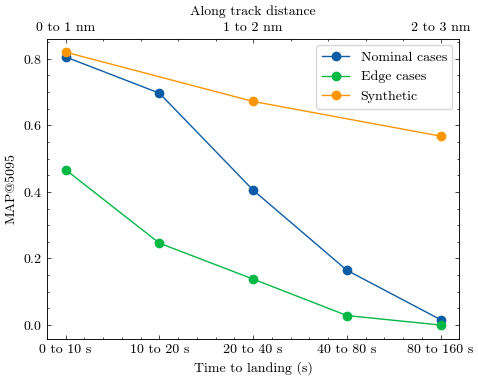

In [ ]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')
plt.rcParams['text.usetex'] = False

def plot_map_along_distance_and_time(metrics_nominal, metrics_edge, metrics_synth):

    # 提取颜色序列
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    # 子图1
    fig, ax = plt.subplots(figsize=(5, 4), dpi=100)
    ln1 = ax.plot(metrics_nominal.columns, metrics_nominal.iloc[0].values, 'o-', color=colors[0], label='Nominal cases')
    ln2 = ax.plot(metrics_edge.columns, metrics_edge.iloc[0].values, 'o-', color=colors[1], label='Edge cases')
    ax.set_xlabel('Time to landing (s)')
    ax.set_ylabel('MAP@5095')
    # ax.set_ylim(0, 1)

    # 子图2
    ax2 = ax.twiny()
    ln3 = ax2.plot(metrics_synth.columns, metrics_synth.iloc[0].values, 'o-', color=colors[2], label='Synthetic')
    ax2.set_xlabel('Along track distance', labelpad=5)

    # 联合legend
    lns = ln1 + ln2 + ln3
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='best', frameon=True)

    plt.tight_layout()
    plt.savefig(
        f'{ROOT_PROJECT}/results/figs/paper/map_vs_distance_and_time.jpg',
        dpi=600, bbox_inches='tight')  # pad_inches=0.0
    plt.show()

plot_map_along_distance_and_time(metrics_nominal, metrics_edge, metrics_synth)